In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import tqdm
from data import load_car_data
from data import load_mnist_data
from data import load_bedroom_data
import matplotlib.pyplot as plt
from model import Generator, Critic
import torchvision


d:\Machine Learning\PROJECTS\WGAN-FROM-SCRATCH-PYTORCH\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def evaluate(generator: Generator, critic: Critic, test_loader, num_data, batch_size, device, latent_dim):
    generator.eval()
    critic.eval()
    progress_bar = tqdm.tqdm(test_loader)
    generator_losses = []
    critic_losses = []
    for i, images in enumerate(progress_bar):
      with torch.no_grad():
            real_img_batch = images.to(device)
            latent_inp = torch.randn(size=(batch_size, latent_dim)).to(device) # (b, h)
            x = torch.unsqueeze(torch.unsqueeze(latent_inp, dim=-1), dim=-1) # (b, h, 1, 1)
            fake_img_batch = generator(x)
            
            # Descriminate
            D_real = critic(real_img_batch).squeeze() # (5, 1)
            D_fake = critic(fake_img_batch).squeeze() # Descrimating Generated image
            
            D_loss = - (D_real.mean() - D_fake.mean())
            G_loss = - (D_fake.mean())         
              
            generator_losses.append(G_loss.item())
            critic_losses.append(D_loss.item())
          
      if i == num_data:
          break
    
    eval_generator_mean_loss = torch.tensor(generator_losses).mean()
    eval_critic_mean_loss = torch.tensor(critic_losses).mean()
    
    # Show a grid of generated images
    latent_inp = torch.randn(size=(16, latent_dim)).to(device) # (b, h)
    x = torch.unsqueeze(torch.unsqueeze(latent_inp, dim=-1), dim=-1) # (b, h, 1, 1)
    fake_samples = generator(x).detach().cpu()
    grid = torchvision.utils.make_grid(fake_samples, nrow=4, normalize=True)
    plt.figure(figsize=(7, 7))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    
    generator.train()
    critic.train()
    
    return eval_critic_mean_loss, eval_generator_mean_loss

def gradient_penalty(critic, real_images, fake_images, device):
    batch_size = real_images.size(0)

    
    
    # Random weight for interpolation between real & fake
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    
    interpolated = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated.requires_grad_(True)

    # Critic score for interpolated images
    interpolated_score = critic(interpolated)

    # Compute gradients of scores w.r.t. interpolated images
    gradients = torch.autograd.grad(
        outputs=interpolated_score,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_score),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Flatten gradients: (batch_size, -1)
    gradients = gradients.view(batch_size, -1)

    # Compute penalty: (||grad||2 - 1)^2
    penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return penalty
 
def train(generator, critic, num_epochs, eval_epoch, device, batch_size, sample_size, n_critic, latent_dim, lambda_g):
    generator.to(device)
    critic.to(device)
    D_optimizer = torch.optim.AdamW(critic.parameters(), lr=1e-4, betas=(0.0, 0.9))
    G_optimizer = torch.optim.AdamW(generator.parameters(), lr=1e-4,betas=(0.0, 0.9))
    train_loader, test_loader = load_bedroom_data(train_batch_size=batch_size, test_batch_size=2, sample_size=sample_size)
    
    
    for epoch in range(num_epochs):
        progress = tqdm.tqdm(train_loader, dynamic_ncols=True)
        generator.train()
        critic.train()
        progress.set_description(f'Epoch: {epoch}')
        generator_losses = []
        critic_losses = []
        
        # print(next(iter(progress)))
        
        for step, images in enumerate(progress):
            real_images = images.to(device)
            
            for _ in range(n_critic):
                
                latent_inp = torch.randn(size=(batch_size, latent_dim)).to(device) # (b, h)
                x = torch.unsqueeze(torch.unsqueeze(latent_inp, dim=-1), dim=-1) # (b, h, 1, 1)
                fake_images = generator(x).detach()
            
                # Descriminate
                D_real = critic(real_images).squeeze() # (5, 1)
                D_fake = critic(fake_images).squeeze() # Descrimating Generated image
                
                gp = gradient_penalty(critic, real_images, fake_images, device)
                
                D_loss =  (D_fake.mean() - D_real.mean()) + lambda_g * gp

                D_optimizer.zero_grad()
                D_loss.backward()
                D_optimizer.step()
            
            G_optimizer.zero_grad()
            latent_inp = torch.randn(size=(batch_size, latent_dim)).to(device) # (b, h)
            x = torch.unsqueeze(torch.unsqueeze(latent_inp, dim=-1), dim=-1) # (b, h, 1, 1)
            fake_images = generator(x)
            D_fake = critic(fake_images).squeeze() # Descrimating Generated image
            G_loss = - torch.mean(D_fake)
            G_loss.backward()
            G_optimizer.step()
            
            generator_losses.append(G_loss.item())
            critic_losses.append(D_loss.item())
            
            progress.set_postfix({'generator_loss': f"{G_loss.item():.4f}", 'critic_loss': f"{D_loss.item():.4f}"})
        
            if (step + 1) % 200 == 0:
                eval_critic_loss, eval_generator_loss = evaluate(generator, critic, test_loader, num_data=20, batch_size=2, device=device, latent_dim=latent_dim)
        
        
        
       
      

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 100
generator = Generator(latent_dim=latent_dim, device=device)
critic = Critic()

In [ ]:
# torch.save(generator, "generator.pt")
# torch.save(critic, "critic.pt")

Epoch: 0:   0%|          | 0/7812 [00:00<?, ?it/s]d:\Machine Learning\PROJECTS\WGAN-FROM-SCRATCH-PYTORCH\data.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trf_image = torch.tensor(transforms(image['image']))
  0%|          | 20/7578 [00:00<00:52, 143.21it/s],  2.02it/s, generator_loss=455.8031, critic_loss=-9.2789] 


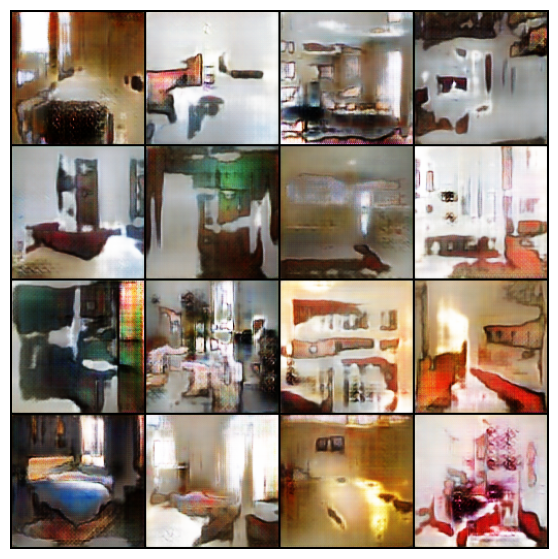

  0%|          | 20/7578 [00:00<00:54, 137.50it/s],  2.01it/s, generator_loss=476.7366, critic_loss=-9.4913] 


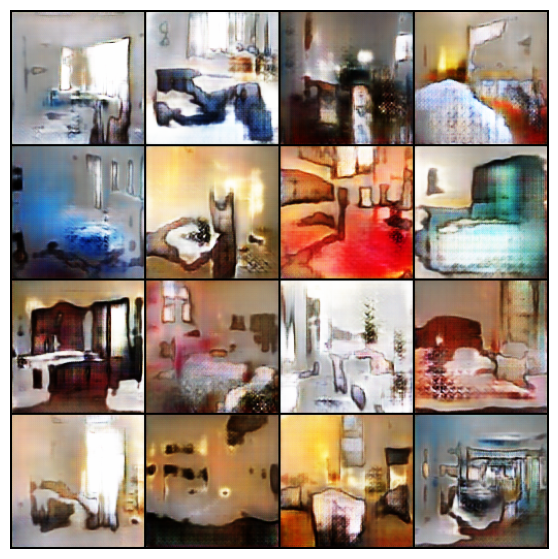

  0%|          | 20/7578 [00:00<00:54, 139.21it/s] 2.02it/s, generator_loss=413.2447, critic_loss=-13.2819]  


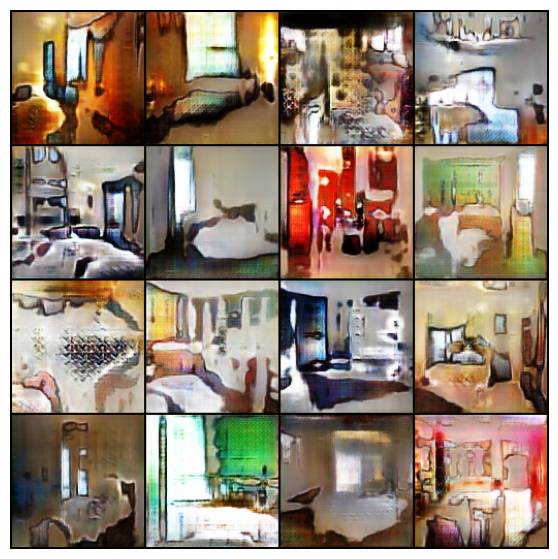

  0%|          | 20/7578 [00:00<00:51, 146.16it/s] 2.01it/s, generator_loss=449.6997, critic_loss=-13.7266]  


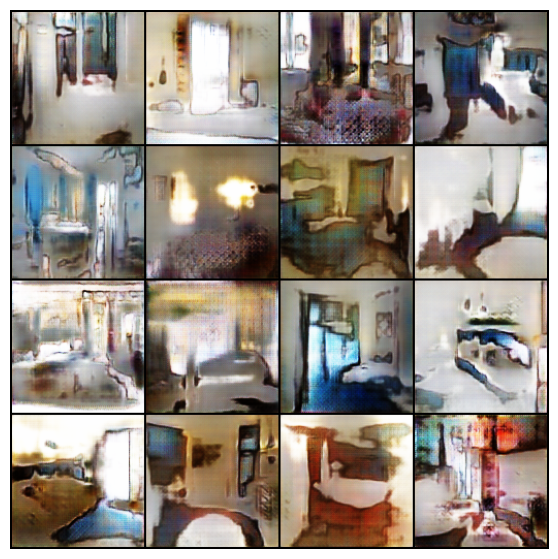

  0%|          | 20/7578 [00:00<00:54, 138.17it/s] 2.05it/s, generator_loss=400.2278, critic_loss=-26.8962]  


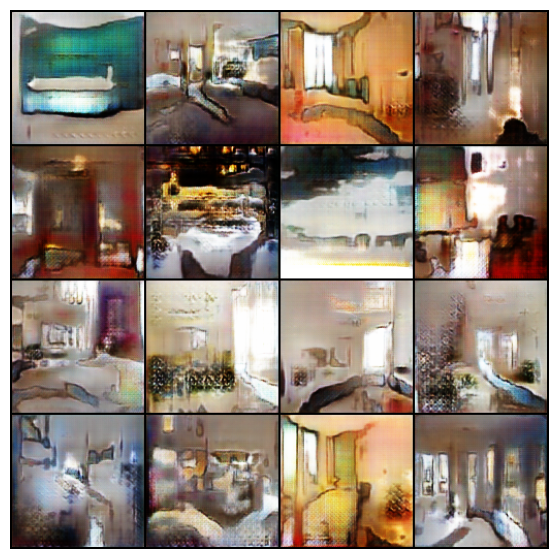

  0%|          | 20/7578 [00:00<00:52, 143.56it/s]  2.03it/s, generator_loss=428.0659, critic_loss=-18.5438]  


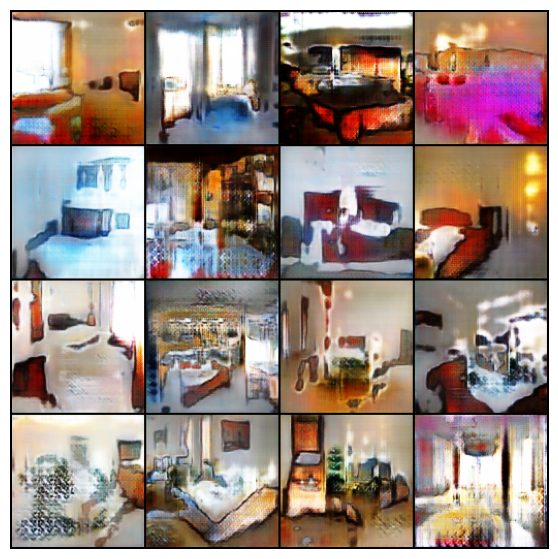

  0%|          | 20/7578 [00:00<00:52, 144.42it/s]  2.05it/s, generator_loss=461.1723, critic_loss=-9.6274]   


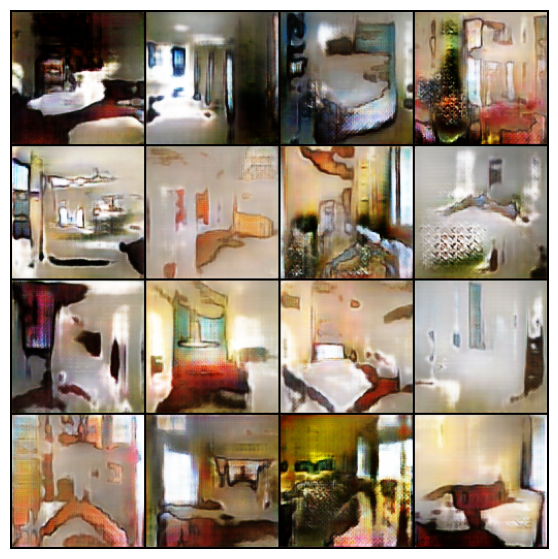

  0%|          | 20/7578 [00:00<00:57, 131.22it/s]  1.97it/s, generator_loss=396.2772, critic_loss=-20.7350]


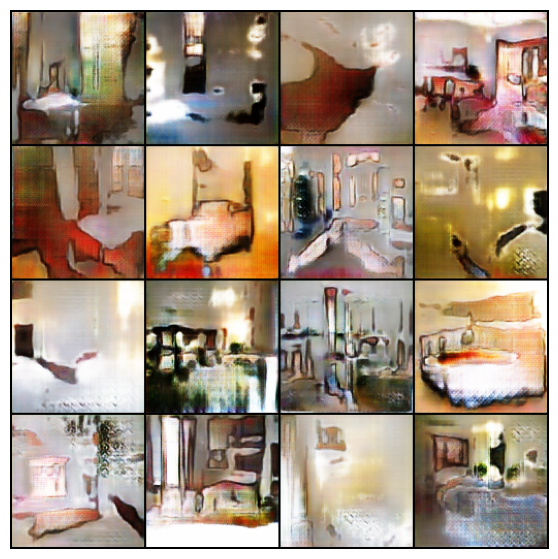

  0%|          | 20/7578 [00:00<00:54, 139.62it/s]  2.02it/s, generator_loss=460.1876, critic_loss=8.8761]    


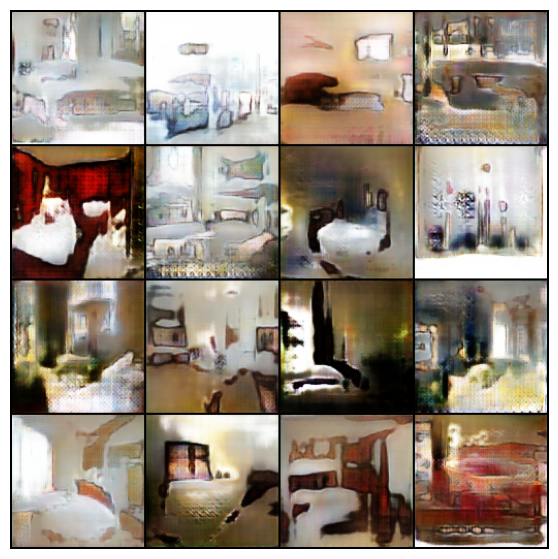

  0%|          | 20/7578 [00:00<00:52, 143.88it/s]  2.04it/s, generator_loss=435.5253, critic_loss=-6.7880] 


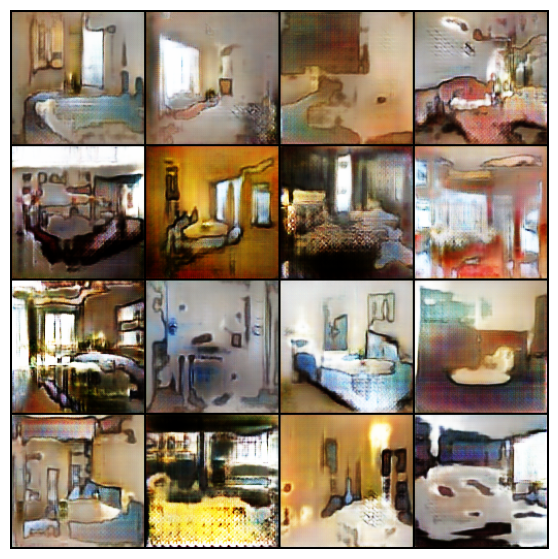

  0%|          | 20/7578 [00:00<00:54, 139.94it/s]  2.02it/s, generator_loss=402.7755, critic_loss=-6.1793] 


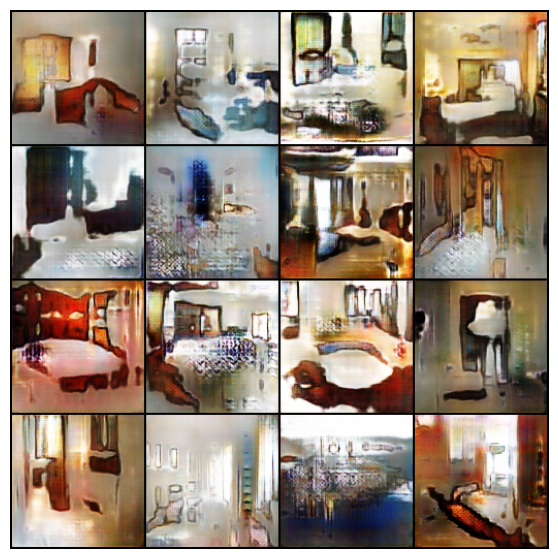

Epoch: 0:  30%|███       | 2363/7812 [19:32<46:00,  1.97it/s, generator_loss=444.1130, critic_loss=-9.4055] 

In [ ]:
train(generator=generator, critic=critic, num_epochs=100, eval_epoch=20, device=device, batch_size=32, sample_size=250000, n_critic=5, latent_dim=latent_dim, lambda_g=10)

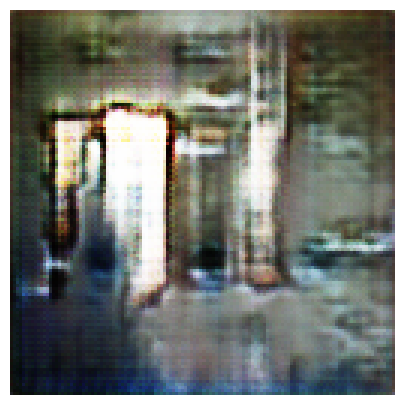

In [17]:
# Show a grid of generated images
latent_inp = torch.randn(size=(1, latent_dim)).to(device) # (b, h)
x = torch.unsqueeze(torch.unsqueeze(latent_inp, dim=-1), dim=-1)
generator.eval()
with torch.no_grad():
    fake_samples = generator(x).detach().cpu()
grid = torchvision.utils.make_grid(fake_samples, nrow=4, normalize=True)
plt.figure(figsize=(5, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()
    